In [141]:
#import the libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [142]:
#Store the data into the df variable
df = pd.read_csv('../../data/ETH.csv')

In [143]:
#Set the date as the index for the data
df = df.set_index(pd.DatetimeIndex(df['begins_at'].values)).tail(5000)
df['price'] = df[['high_price','low_price']].mean(axis=1)
df['real_price'] = df.price
df['price'] = df.price.ewm(span=6, adjust=True).mean()

Text(0, 0.5, 'Price USD ($)')

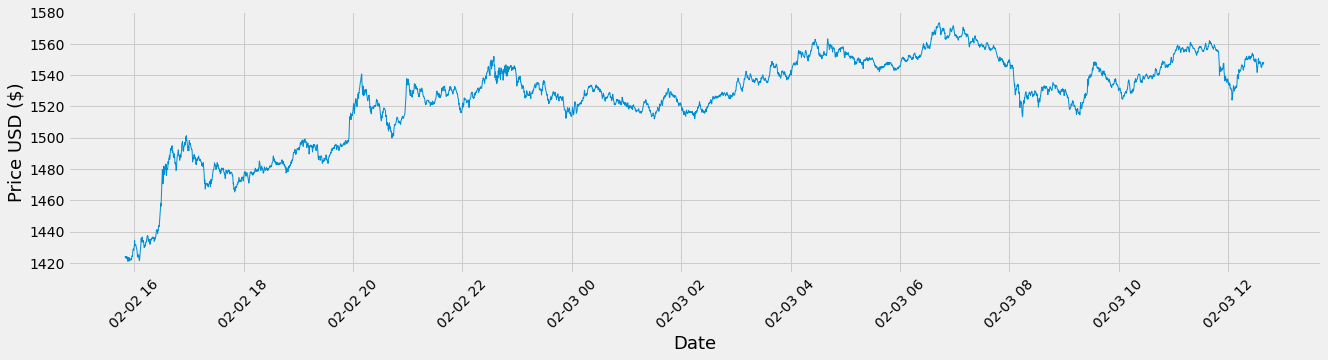

In [144]:
# Visually Show The Stock Price(s)
# Create the title
title = 'ETH Price'
#Get the stocks
my_stocks = df
#Create and plot the graph
plt.figure(figsize=(20,4.5)) #width = 12.2in, height = 4.5
plt.plot( my_stocks['price'],  label='price', linewidth=1)#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)

plt.xticks(rotation=45) 
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD ($)',fontsize=18)
# plt.show()

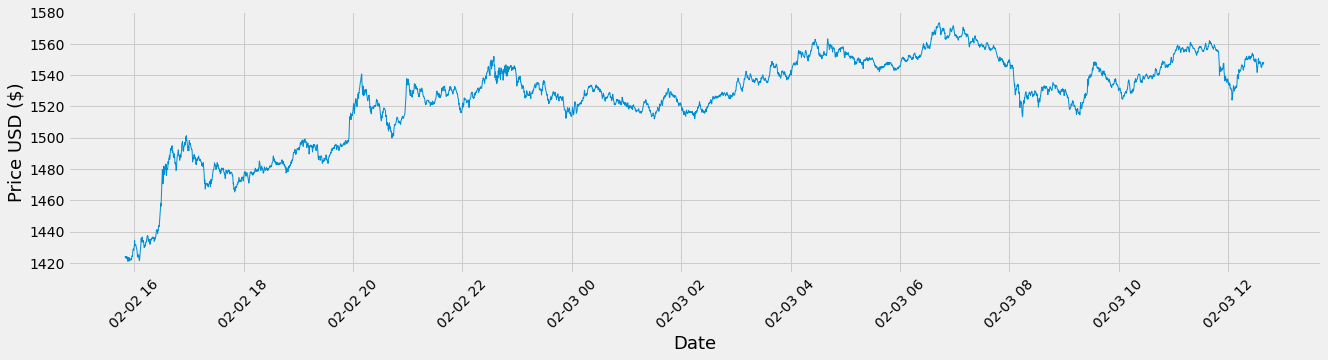

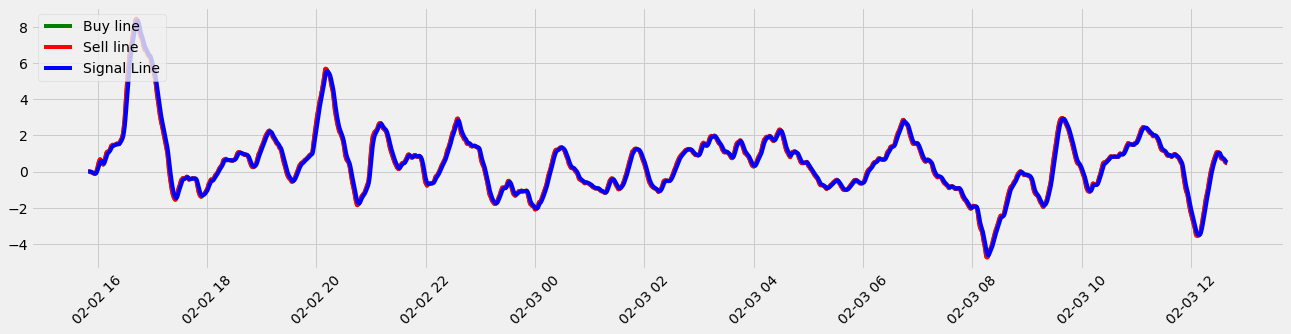

In [145]:
def createMacdAndSignalLines(dataset, macd_params, macd_multiplier):
    ShortEMA = dataset.ewm(span=macd_params[0]*macd_multiplier, min_periods=macd_multiplier, adjust=False).mean() #AKA Fast moving average
    LongEMA = dataset.ewm(span=macd_params[1]*macd_multiplier, min_periods=macd_multiplier, adjust=False).mean() #AKA Slow moving average
    Macd = ShortEMA - LongEMA
    signal = Macd.ewm(span=macd_params[2]*macd_multiplier, min_periods=macd_multiplier, adjust=False).mean()
    return (Macd, signal)

macd_params = (20*4, 30*4, 11)
macd_multiplier = 1
# ndf = df.price.ewm(span=100, adjust=True).mean() if using this make it 20, 20
macd_buy, signal = createMacdAndSignalLines(df.price, macd_params, macd_multiplier)
macd_sell, _ = createMacdAndSignalLines(df.price, macd_params, macd_multiplier)
plt.figure(figsize=(20,4.5)) #width = 12.2in, height = 4.5
plt.plot( my_stocks['price'],  label='price', linewidth=1)#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)

plt.xticks(rotation=45) 
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD ($)',fontsize=18)

plt.figure(figsize=(20,4.5)) #width = 12.2in, height = 4.5
plt.plot(df.index, macd_buy, label='Buy line', color = 'green')
plt.plot(df.index, macd_sell, label='Sell line', color = 'red')
plt.plot(df.index, signal, label='Signal Line', color='blue')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()
# profit, trans = mac_daddy_tester(MACD, signal, df)
# print((i, profit))
# t.insert((i, profit))

In [146]:
df['MACD_buy'] = macd_buy
df['MACD_sell'] = macd_sell
df['Signal Line'] = signal

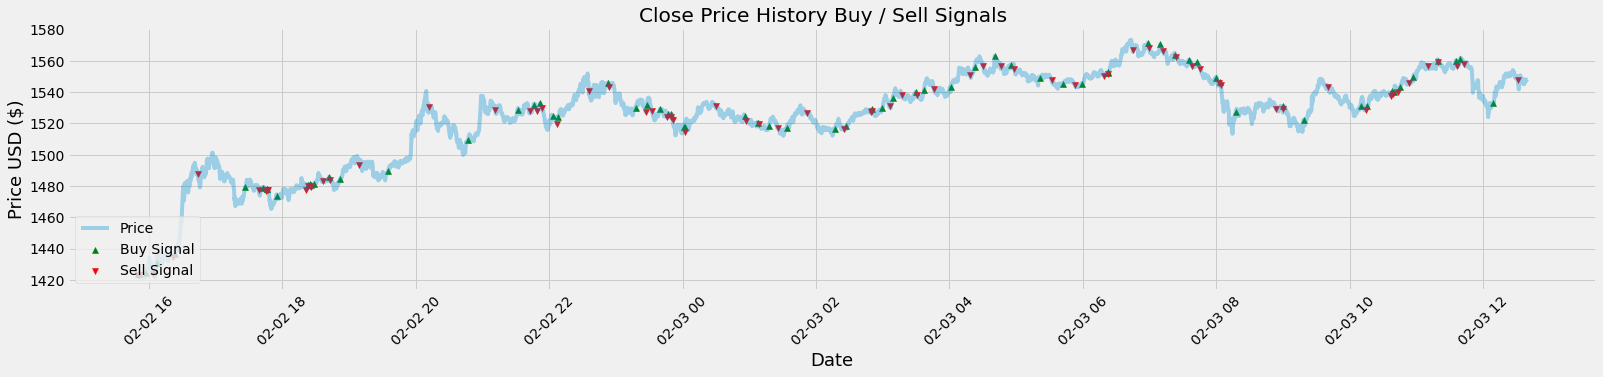

2021-02-02T16:22:00Z Bought at 1433.445  selling at 1437.675 for profit: +3.23
2021-02-02T16:44:15Z Bought at 1432.61  selling at 1482.775 for profit: +49.17
2021-02-02T17:39:00Z Bought at 1483.585  selling at 1477.08 for profit: -7.51
2021-02-02T17:45:15Z Bought at 1482.675  selling at 1477.435 for profit: -6.24
2021-02-02T17:46:15Z Bought at 1478.36  selling at 1482.3 for profit: +2.94
2021-02-02T17:47:00Z Bought at 1473.045  selling at 1473.04 for profit: -1.01
2021-02-02T18:21:30Z Bought at 1470.585  selling at 1473.275 for profit: +1.69
2021-02-02T18:23:30Z Bought at 1486.285  selling at 1484.855 for profit: -2.43
2021-02-02T18:25:15Z Bought at 1484.645  selling at 1477.155 for profit: -8.49
2021-02-02T18:25:45Z Bought at 1480.81  selling at 1475.945 for profit: -5.87
2021-02-02T18:37:00Z Bought at 1481.025  selling at 1477.83 for profit: -4.20
2021-02-02T18:42:30Z Bought at 1490.225  selling at 1485.175 for profit: -6.05
2021-02-02T19:09:15Z Bought at 1489.44  selling at 1493.54 

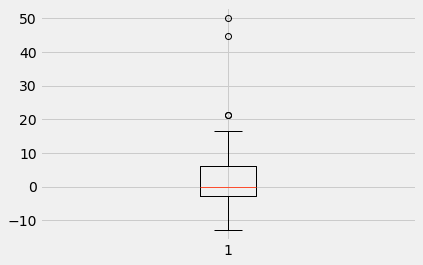

In [147]:
# Function to test the crossover driven profits of the macd and signal lines
def mac_daddy_tester(macd_buy, macd_sell, signal, df, quiet=False):
    bought = False
    sumwin = 0
    transactions = []
    for i in range(50, len(signal)):
        if ( (macd_buy.iat[i] > signal.iat[i]) and (macd_buy.iat[i-1] <= signal.iat[i-1]) and bought == False):
            # print("Crossed above, time to buy", i)
            bought = df.iat[i,1]
        if ( (macd_sell.iat[i] < signal.iat[i]) and (macd_sell.iat[i-1] >= signal.iat[i-1]) and bought):
            # print("Crossed below, time to sell", i)
            if not quiet:
              print(df.iat[i,0], "Bought at", bought, " selling at", df.iat[i,1], f"for profit: {df.iat[i,1] - bought - 1:+.2f}")
            transactions.append(df.iat[i,1] - bought)
            sumwin = sumwin + df.iat[i,1] - bought - 1
            bought = False 
    return(sumwin, transactions)


#Create a function to signal when to buy and sell an asset
def buy_sell(signal):
  sigPriceBuy = []
  sigPriceSell = []
  flag = 0
  for i in range(0,len(signal)):
    #if MACD > signal line  then buy else sell
      if signal['MACD_buy'][i] > signal['Signal Line'][i]:
        if flag != 1:
          sigPriceBuy.append(signal['price'][i])
          sigPriceSell.append(np.nan)
          flag = 1
        else:
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
      elif signal['MACD_sell'][i] < signal['Signal Line'][i]: 
        if flag != 0:
          sigPriceSell.append(signal['price'][i])
          sigPriceBuy.append(np.nan)
          flag = 0
        else:
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
      else: #Handling nan values
        sigPriceBuy.append(np.nan)
        sigPriceSell.append(np.nan)
  
  return (sigPriceBuy, sigPriceSell)


#Create buy and sell columns
x = buy_sell(df)
df['Buy_Signal_Price'] = x[0]
df['Sell_Signal_Price'] = x[1]

# Visually Show The Stock buy and sell signals
# Create the title 
title = 'Close Price History Buy / Sell Signals   '
#Get the stocks
my_stocks = df
  
#Create and plot the graph
plt.figure(figsize=(12.2*2,4.5)) #width = 12.2in, height = 4.5
plt.scatter(my_stocks.index, my_stocks['Buy_Signal_Price'], color = 'green', label='Buy Signal', marker = '^', alpha = 1)
plt.scatter(my_stocks.index, my_stocks['Sell_Signal_Price'], color = 'red', label='Sell Signal', marker = 'v', alpha = 1)
plt.plot( my_stocks['price'],  label='Price', alpha = 0.35)#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)
# plt.plot( df.price,  label='Price', linewidth=1, color='blue')#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)
plt.xticks(rotation=45)
plt.title(title)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD ($)',fontsize=18)
plt.legend( loc='lower left')
plt.show()

r = mac_daddy_tester(macd_buy, macd_sell, signal, df)
print("Profit", r[0])
print("trans: ", len(r[1]))
# print(r[1])
plt.boxplot(r[1])
plt.show()

In [148]:
# results = []
# macd_params = (12, 26, 9)
# max_p = 0
# for period_length1 in np.arange(1, 300, 1):
#     for period_length2 in np.arange(1, 300, 1):
#         macd_buy, signal = createMacdAndSignalLines(df.price, macd_params, period_length1)
#         macd_sell, _ = createMacdAndSignalLines(df.price, macd_params, period_length2)
#         r = mac_daddy_tester(macd_buy, macd_sell, signal, df, quiet=True)
#         results.append((period_length1, period_length1, r[0], len(r[1])))
#         if r[0] > max_p:
#             max_p = r[0]
#             print("Buy period:", period_length1, "Sell period:", period_length2, "Profit", r[0], "transactions: ", len(r[1]))
#     # print(sorted(results, key = lambda x: -x[2]))

In [149]:
# # print(sorted(results, key = lambda x: -x[2]))
# maxi = 0
# for r in results:
#     if r[2] >= maxi:
#         maxi = r[2]
#         print(r)